References:
    https://zhuanlan.zhihu.com/p/113685503
    https://www.kalmanfilter.net/
    https://zhuanlan.zhihu.com/p/77327349 通俗易懂的解释
    观测值分布核预测值分布的乘积（贝叶斯滤波进行解释） https://www.zhihu.com/question/23971601/answer/770830003
    https://www.jianshu.com/p/42145f1077e5 图解 公式比较好理解

application：
    1、car tracking： https://zhuanlan.zhihu.com/p/148046908

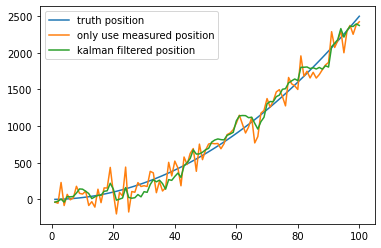

In [9]:
#实现1 https://zhuanlan.zhihu.com/p/77327349
import numpy as np
t = np.linspace(1,100,100) # 在1~100s内采样100次
a = 0.5 # 加速度值
position = (a * t**2)/2

position_noise = position+np.random.normal(0,120,size=(t.shape[0])) # 模拟生成GPS位置测量数据（带噪声）
import matplotlib.pyplot as plt
plt.plot(t,position,label='truth position')
plt.plot(t,position_noise,label='only use measured position')


#---------------卡尔曼滤波----------------
# 初始的估计导弹的位置就直接用GPS测量的位置
predicts = [position_noise[0]]
position_predict = predicts[0]

predict_var = 0
odo_var = 120**2 #这是我们自己设定的位置测量仪器的方差，越大则测量值占比越低
v_std = 50 # 预测方差？测量仪器的方差（这个方差在现实生活中是需要我们进行传感器标定才能算出来的，可搜Allan方差标定）
for i in range(1,t.shape[0]):
    dv =  (position[i]-position[i-1]) + np.random.normal(0,50) # 模拟从IMU读取出的速度
    position_predict = position_predict + dv # 利用上个时刻的位置和速度预测当前位置
    predict_var += v_std**2 # 更新预测数据的方差
    # 下面是Kalman滤波
    position_predict = position_predict*odo_var/(predict_var + odo_var)+position_noise[i]*predict_var/(predict_var + odo_var)
    predict_var = (predict_var * odo_var)/(predict_var + odo_var)#两个高斯分布的联合分布后的方差更新
    predicts.append(position_predict)
    
plt.plot(t,predicts,label='kalman filtered position')

plt.legend()
plt.show()

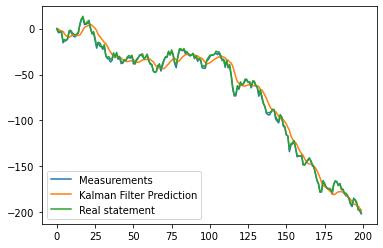

In [8]:
#实现2
#作者：Caliber
#链接：https://zhuanlan.zhihu.com/p/113685503
#公式解释：https://www.jianshu.com/p/42145f1077e5

import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B #干扰为0，加速度为0
        self.Q = np.eye(self.n) if Q is None else Q # 协方差的外部干扰
        self.R = np.eye(self.n) if R is None else R # R为测量方差，为定值
        self.P = np.eye(self.n) if P is None else P#初始变量的协方差为I
        self.x = np.zeros((self.n, 1)) if x0 is None else x0#初始值

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u) #x_k=F_k*x_{k-1}+B*u
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q #协方差更新Q为状态噪声的协方差
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)#公式中的(u1-u0)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))#
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))#求K'的公式，详见上述链接中求K的公式，K为卡尔曼增益
        self.x = self.x + np.dot(K, y)#更新后的x
        I = np.eye(self.n)
        self.P = np.dot(I - np.dot(K, self.H), self.P)#更新后的协方差P_k'

def example():
    dt = 1.0/60
    F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])#状态转移方程
    H = np.array([1, 0, 0]).reshape(1, 3)
    Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])#外部干扰
    R = np.array([1]).reshape(1, 1)#sigma1，测量的方差不变
    #其中Q为状态噪声的方差，R为测量噪声的方差
    
    itr  = 200
    
    def f(x):
        return np.dot(F,x)+np.random.normal(0,5,3)#np.random.normal(mu, sigma, 1000)
    
    real_state = []
    #位移，速度，加速度
    x = np.array([0,0,0])
    
    for i in range(itr):
        real_state.append(x[0])#位置
        x = f(x)
    
    measurements = [x-1+np.random.normal(0,1) for x in real_state]#观测，x-1+v

    kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
    predictions = []
    for z in measurements:
        predictions.append(kf.predict()[0])
        kf.update(z)

    import matplotlib.pyplot as plt
    plt.plot(range(len(measurements)), measurements, label = 'Measurements')
    plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
    plt.plot(range(len(real_state)), real_state, label = 'Real statement' )
    plt.legend()
    plt.show()

if __name__ == '__main__':
    example()